In [22]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix ,classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")   

In [3]:


data_dir = "/kaggle/input/gtsrb-german-traffic-sign"

# Load the training CSV file
train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))

# Number of unique classes (should be 43)
nb_classes = train_csv["ClassId"].nunique()
print("Number of classes:", nb_classes)

classes = {
    0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)',
    9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection',
    12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 16:'Veh > 3.5 tons prohibited',
    17:'No entry', 18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right',
    21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right',
    25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing',
    29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing',
    32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead',
    35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 38:'Keep right',
    39:'Keep left', 40:'Roundabout mandatory', 41:'End of no passing', 42:'End no passing veh > 3.5 tons'
}

# Create a mapping: classid -> class name
class_names_label = classes

# Example lookup
print("Class 2 means:", class_names_label[2])


Number of classes: 43
Class 2 means: Speed limit (50km/h)


In [4]:
IMAGE_SIZE = (64, 64)
def load_data(df, base_dir):
    images = []
    labels = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(base_dir, row["Path"])
        label = row["ClassId"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE)

        # Normalization
        image = image.astype("float32") / 255.0

        images.append(image)
        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")
    return images, labels


# load
test_csv  = pd.read_csv(os.path.join(data_dir, "Test.csv"))

train_images, train_labels = load_data(train_csv, data_dir)
test_images, test_labels = load_data(test_csv, data_dir)


100%|██████████| 12630/12630 [01:52<00:00, 112.11it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples:", n_train)
print("Number of testing examples:", n_test)
print("Each image is of size:", IMAGE_SIZE)

Number of training examples: 39209
Number of testing examples: 12630
Each image is of size: (64, 64)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.15, random_state=44, stratify=train_labels
)
X_test,y_test = (test_images, test_labels)

In [ ]:
# model - DenseNet169 with frozen layers
base_model = tf.keras.applications.DenseNet169(
    include_top=False,          # remove default classifier
    weights="imagenet",
    input_shape=(64, 64, 3),  # image size
    pooling=None
)

# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# build Sequential model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(43, activation="softmax")
])
# compile
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
# callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
model.summary()

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 2, 2, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       426,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,080,171 (49.90 MB)

 Trainable params: 437,291 (1.67 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size = 128,
    epochs = 1,
    validation_data=(X_val, y_val),
    )

261/261 ━━━━━━━━━━━━━━━━━━━━ 1076s 4s/step - accuracy: 0.9960 - loss: 0.0135 - val_accuracy: 0.9942 - val_loss: 0.0292


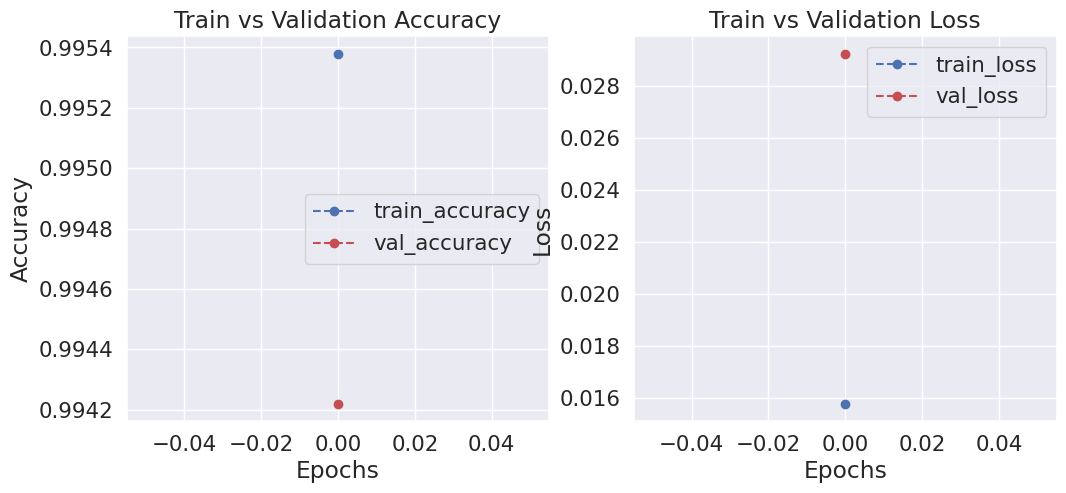

In [19]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,5))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], 'bo--', label='train_accuracy')
    plt.plot(history.history['val_accuracy'], 'ro--', label='val_accuracy')
    plt.title("Train vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], 'bo--', label='train_loss')
    plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
    plt.title("Train vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()
plot_accuracy_loss(history=history)

In [23]:
pred_probs = model.predict(test_images)         
pred_labels = np.argmax(pred_probs, axis=1)
classes = [str(i) for i in range(43)]

print("Classification Report:")
print(classification_report(test_labels, pred_labels, target_names=classes))

395/395 ━━━━━━━━━━━━━━━━━━━━ 95s 242ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.94      0.98      0.96       720
           2       0.99      1.00      0.99       750
           3       0.95      0.98      0.96       450
           4       0.99      0.98      0.98       660
           5       0.93      0.98      0.95       630
           6       1.00      0.74      0.85       150
           7       0.97      0.95      0.96       450
           8       0.95      0.97      0.96       450
           9       0.96      1.00      0.98       480
          10       1.00      0.99      1.00       660
          11       0.99      0.98      0.98       420
          12       0.95      0.98      0.97       690
          13       0.99      0.99      0.99       720
          14       0.97      1.00      0.98       270
          15       0.94      1.00      0.97       210
          16  

In [24]:
loss, acc = model.evaluate(test_images, test_labels, verbose=0)
print("Test accuracy:", acc)

Test accuracy: 0.9670625329017639


In [25]:
model.save("DenseNet169.keras")